Initial explorations of calcium imaging data from V1DD dataset.

**Summary.**
- Focused exploration on column 1, volume 3 of the Golden Mouse, and the `natural_images_12` stimulus.
- Surprised by the initial "burst" of activity across the first 3 presentations of the `natural_images_12` stimulus set (~12 sec) that then decays to a more stationary response.
  - This may be attributable to V1 acclimating the a new visual stimulus (particularly since it falls after the `spontaneous` epoch), but let's inspect responses at a more global scale before pursuing further analyses.

*Additional notes*
- Regressing behavior out via a simple linear regression model did not affect responses at all.
  - Do not include `corneal_reflection` in variables; that is simply an intermediate variable to help localize the pupil to fit a pupil size.

**Next steps**
- Visualize population average activity over the whole session, across all volumes, to get a better handle of stimulus locking of responses.
- Factor out the helper functions for rest of team to use.

In [1]:
# general imports 
import os
from pathlib import Path
from pprint import pprint
from tqdm.auto import tqdm

import numpy as np
import scipy
import pandas as pd 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

# nwb specific imports 
import pynwb
from nwbwidgets import nwb2widget
from hdmf_zarr import NWBZarrIO 

In [2]:
# Specify data directory location
DATA_DIR = "/data/"  # Code Ocean

# Load metadata csv, which contains session, subject, column, and volume info
metadata = pd.read_csv('/root/capsule/metadata/V1DD_metadata.csv')

## Load a session of data

We focus on a middle-depth volume (`volume=3`) in the center imaging column (`column=1`) of the Golden Mouse.

In [3]:
# Load session data
def load_session(session_name, data_dir=DATA_DIR):
    """Load NWB path to specified session."""

    # construct path (relative to data_dir) to session
    subject_id = session_name.split('_')[0]
    is_golden_mouse = (int(subject_id) == 409828)

    subdir_name = f"{subject_id}_V1DD"
    subdir_name += "_GoldenMouse" if is_golden_mouse else ""

    data_fpath = os.path.join(subdir_name, session_name, session_name+'.nwb.zarr')

    # Load nwb path
    nwb_path_zarr = os.path.join(data_dir, data_fpath)
    io = NWBZarrIO(nwb_path_zarr, mode='r')
    nwb = io.read()

    return nwb

selected_session = metadata[
    (metadata['golden_mouse']==True)    # mouse with structural info
    & (metadata['column']==1)           # center imaging column
    & (metadata['volume']==3)           # not top or bottom volume
]

assert len(selected_session) == 1, f"Expected exactly 1 session, got {len(selected_session)}"

nwb = load_session(selected_session.name.item())

/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.9.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


### Align data from all planes

Align the dF/F traces for all planes in the volume by the timestamp of the first plane.

In [4]:
def get_aligned_session_data(nwb, remove_known_bad_planes=True):
    """TODO Just takes in nwb file...
    Adapted from Sven's ```data_extraction/2Ppreprocessing.ipynb``` notebook.

    Parameters
    ----------
    volume : int.
        Imaging volume (depth), 1 = top volume, 5 = bottom volume..

    remove_known_bad_planes : bool.
        Remove plane 6 of (column 1, volume 5).
        Default: True.

    column : int.
        Imaging column. 1 = center, 2-5 = surround.
        Default: 1, center column.

    subject_id : int
        Default: 409828, i.e. the Golden Mouse

    Returns
    -------
    dict of np.ndarray, consisting of:
        timestamps : shape (n_timestamps,)
        dff_traces : shape (n_cells, n_timestamps)
            dF/F traces for all valid neurons across all planes,
            aligned to `timestamps`
        plane_ids : shape (n_cells,)
            Unique ID of plane of cell, ranges from 1-6
        roi_ids
            Unique ID of cell, for the given plane

    """
    plane_ids = range(6)
    if remove_known_bad_planes:
        print("WARNING: Ignoring `remove_known_bad_planes`; not removing any planes")
        # Not sure how to recover column and volume data from NWB
        # if column == 1 and volume == 5:
        #     plane_ids = range(5)
    
    # Use plane-0 timestamps as reference timestamps
    refr_timestamps = nwb.processing['plane-0'].data_interfaces['dff'].timestamps[:]

    all_dff_traces, all_roi_ids, all_plane_ids = [], [], []
    for plane_id in tqdm(plane_ids):
        this_plane = nwb.processing[f'plane-{plane_id}'].data_interfaces

        # Get dF/F traces for valid rois
        rois = this_plane['image_segmentation']['roi_table'][:]
        good_rois = rois[rois.is_soma==True].roi.values
        
        dff_traces = this_plane['dff'].data[:,good_rois].T  # shape (n_cells, n_timestamps)
        
        # Interpolate traces from these timestamps to reference timestamps
        these_timestamps = this_plane['dff'].timestamps[:]
        f_interp = scipy.interpolate.interp1d(
            these_timestamps, dff_traces, 
            kind='linear', bounds_error=False, fill_value="extrapolate",
            axis=-1, # timestamp axis
        )
        interp_dff_traces = f_interp(refr_timestamps)
        
        all_dff_traces.extend(interp_dff_traces)
        all_roi_ids.extend(good_rois)
        all_plane_ids.extend([plane_id] * len(good_rois))
        
    all_dff_traces = np.array(all_dff_traces)               # (n_total_cells, n_timestamps)
    all_plane_ids = np.array(all_plane_ids, dtype=int)      # (n_total_cells,)
    all_roi_ids = np.array(all_roi_ids, dtype=int)          # (n_total_cells,)
    
    return {
        "dff_traces": all_dff_traces,
        "plane_ids": all_plane_ids,
        "roi_ids": all_roi_ids,
        "timestamps": refr_timestamps,
    }

session_data = get_aligned_session_data(nwb)

  0%|          | 0/6 [00:00<?, ?it/s]

In [5]:
nbytes = 0
for k, v in session_data.items():
    nbytes += v.nbytes

print(f"Total session data: {nbytes / (2**20):.2f} MB")

print()
print(f"{session_data['dff_traces'].shape=}")

Total session data: 446.80 MB

session_data['dff_traces'].shape=(2708, 21616)


## Evaluate by stimulus condition

**Stimulus "epochs"**

In [6]:
nwb.epochs.to_dataframe()

,stim_name,start_time,stop_time,duration
id,,,,
0,drifting_gratings_full,54.634430,341.856873,287.222443
1,drifting_gratings_windowed,344.876038,632.098572,287.222534
2,locally_sparse_noise,635.117737,875.334412,240.216675
3,spontaneous,876.318604,1176.552002,300.233398
4,natural_images_12,1179.571167,1331.681152,152.109985
5,natural_movie,1343.707764,1794.066162,450.358398
6,locally_sparse_noise,1798.119507,2098.236084,300.116577
7,natural_images,2100.337891,2399.503662,299.165771
8,drifting_gratings_windowed,2414.599609,2701.822021,287.222412


**First few rows of `stimulus_table`**

In [7]:
stimulus_table = nwb.intervals['stimulus_table'].to_dataframe()
stimulus_table.head()

,stim_name,start_time,stop_time,temporal_frequency,spatial_frequency,direction,frame,image_order,image_index,stimulus_condition_id
id,,,,,,,,,,
0,drifting_gratings_full,54.634430,56.619442,1.0,0.04,30.0,NaN,NaN,NaN,1
1,drifting_gratings_full,57.636951,59.622009,1.0,0.08,300.0,NaN,NaN,NaN,22
2,drifting_gratings_full,60.639420,62.624439,1.0,0.04,300.0,NaN,NaN,NaN,10
3,drifting_gratings_full,63.641949,65.626930,1.0,0.08,300.0,NaN,NaN,NaN,22
4,drifting_gratings_full,66.644447,68.629433,1.0,0.04,330.0,NaN,NaN,NaN,11


### Evaluate `natural_images_12` response

*Stimulus set description*
- A subset of 12 images from the 118 images of the Visual Coding stimulus set
- Images were presented in a frozen sequence, and repeated 40 times
- Images were switched at 3Hz. This accomodates the slower imaging rate of the DeepScope

First, let's treat each sequence of images as a response, i.e. we have 40 responses of length (12 images / 3 Hz ~= 4 sec).

In [8]:
selected_stimulus = 'natural_images_12'
selected_stimulus_table = stimulus_table[stimulus_table['stim_name'] == selected_stimulus]

start_times = selected_stimulus_table[
    selected_stimulus_table['image_order'] == 0
]['start_time'].values
stop_times = selected_stimulus_table[
    selected_stimulus_table['image_order'] == 11
]['stop_time'].values

timestamps = session_data['timestamps']
start_indices = np.array(
    [np.nonzero(timestamps >= start_time)[0][0] for start_time in start_times]
)

stop_indices = np.array(
    [np.nonzero(timestamps <= stop_time)[0][-1]+1 for stop_time in stop_times]
)

assert len(start_indices)==40, f"Expected 40 start times, got {len(start_indices)}."
assert len(stop_indices)==40, f"Expected 40 stop times, got {len(stop_indices)}."

In [9]:
plane_ids = session_data['plane_ids']
y_cluster_edges = np.nonzero(plane_ids[1:] - plane_ids[:-1])[0] + 1

y_cluster_centers = np.concatenate([
    [0.5*y_cluster_edges[0]],  # first cluster
    0.5*(y_cluster_edges[1:] - y_cluster_edges[:-1]) + y_cluster_edges[:-1],
    [0.5*(len(plane_ids) - y_cluster_edges[-1]) + y_cluster_edges[-1]]  # last cluster
])

y_cluster_labels = [f'plane-{plane_id}' for plane_id in np.unique(plane_ids)]


Text(0.5, 0.95, 'natural_images_12, first 10 presentations')

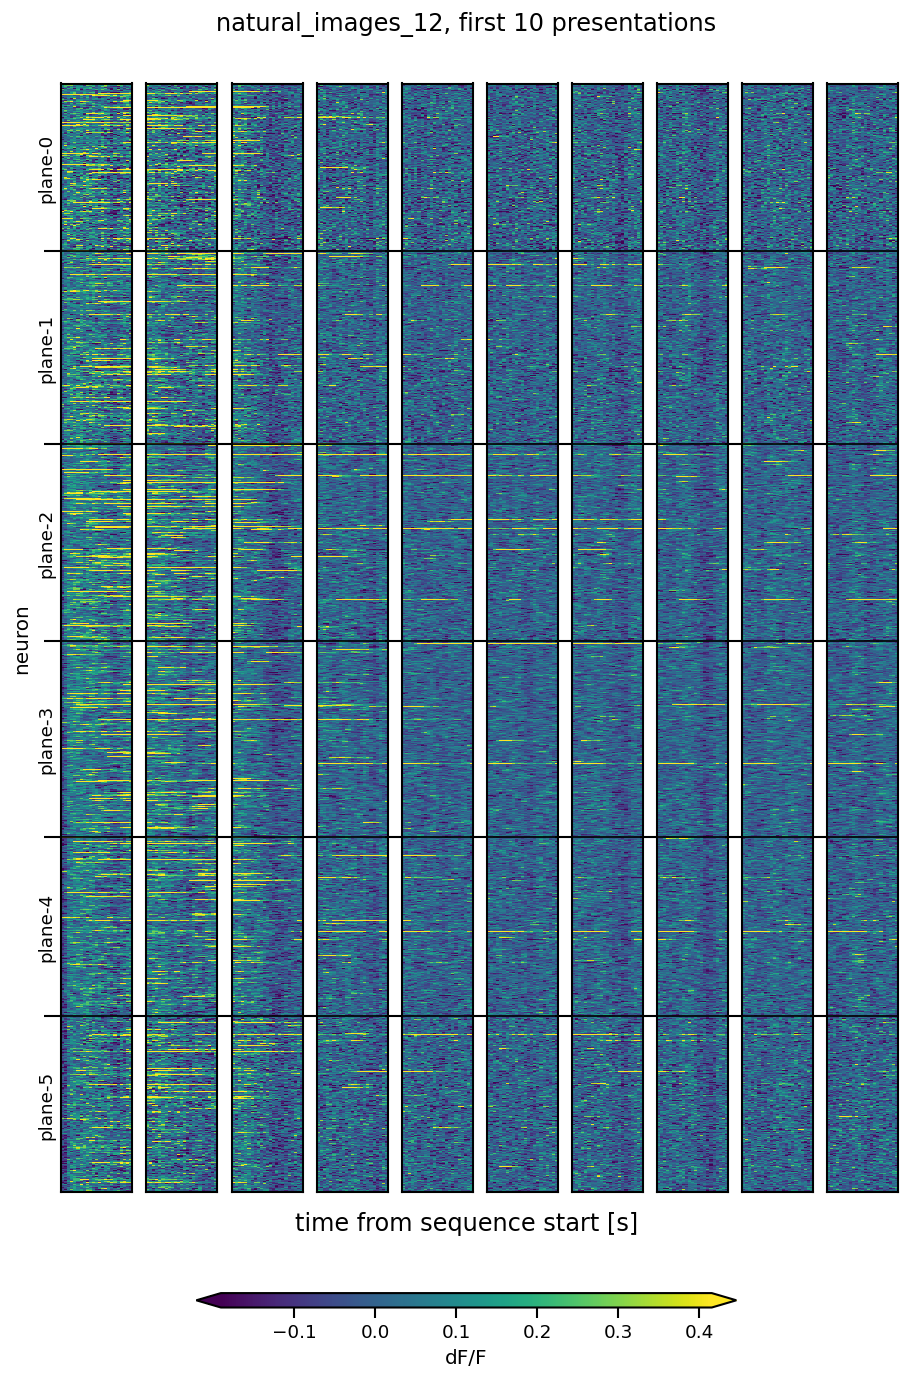

In [10]:
dff = session_data['dff_traces']
plane_ids = session_data['plane_ids']

# Set color norm
norm = mpl.colors.Normalize(
    vmin=np.percentile(dff[:, start_indices[0]:stop_indices[-1]], 1),
    vmax=np.percentile(dff[:, start_indices[0]:stop_indices[-1]], 99),
)

fig, axs = plt.subplots(ncols=10, sharex=True,sharey=True, figsize=(9,12), dpi=120)
for ax, start_index, stop_index in zip(axs, start_indices, stop_indices):
    im = ax.imshow(
        dff[:,start_index:stop_index],
        norm=norm, interpolation='none', aspect='auto'
    )

    for edge in y_cluster_edges:
        ax.axhline(edge, color='k', lw=1)

    # Annotate y-axis with plane
    ax.set_yticks(y_cluster_edges)
    ax.tick_params(axis='y', labelleft=False, length=10)
    
    ax.set_yticks(y_cluster_centers, minor=True)
    ax.set_yticklabels(y_cluster_labels, minor=True, rotation=90, va='center',)
    ax.tick_params(axis='y', which='minor', left=False, length=0)
    
    # Hide x-axis ticks
    ax.tick_params(labelbottom=False, bottom=False)

    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel('neuron')

fig.supxlabel("time from sequence start [s]", y=0.10)

# Add color bar
fig.subplots_adjust(top=0.9, bottom=0.13)
cax = fig.add_axes((0.25,0.05, 0.5, 0.01))   # (l,b,w,h)
fig.colorbar(im, cax=cax, extend='both', label='dF/F', orientation='horizontal')

# Add title
fig.suptitle("natural_images_12, first 10 presentations", y=0.95)

It is surprising that the there is pretty big difference in the stimulus response during the first 2-3 sessions vs. the later sessions. Is this an artifact, or some preprocessing issue?

Other observations
- Fairly consistent strong suppression of activities in the second half (blue vertical stripe)
- Some cells do seem to fire strongly and reliably with the sequence
- Different planes seem to have more noise (e.g. plane 0 and plane 5) than others

Text(0.5, 0.95, 'natural_images_12, last 10 presentations')

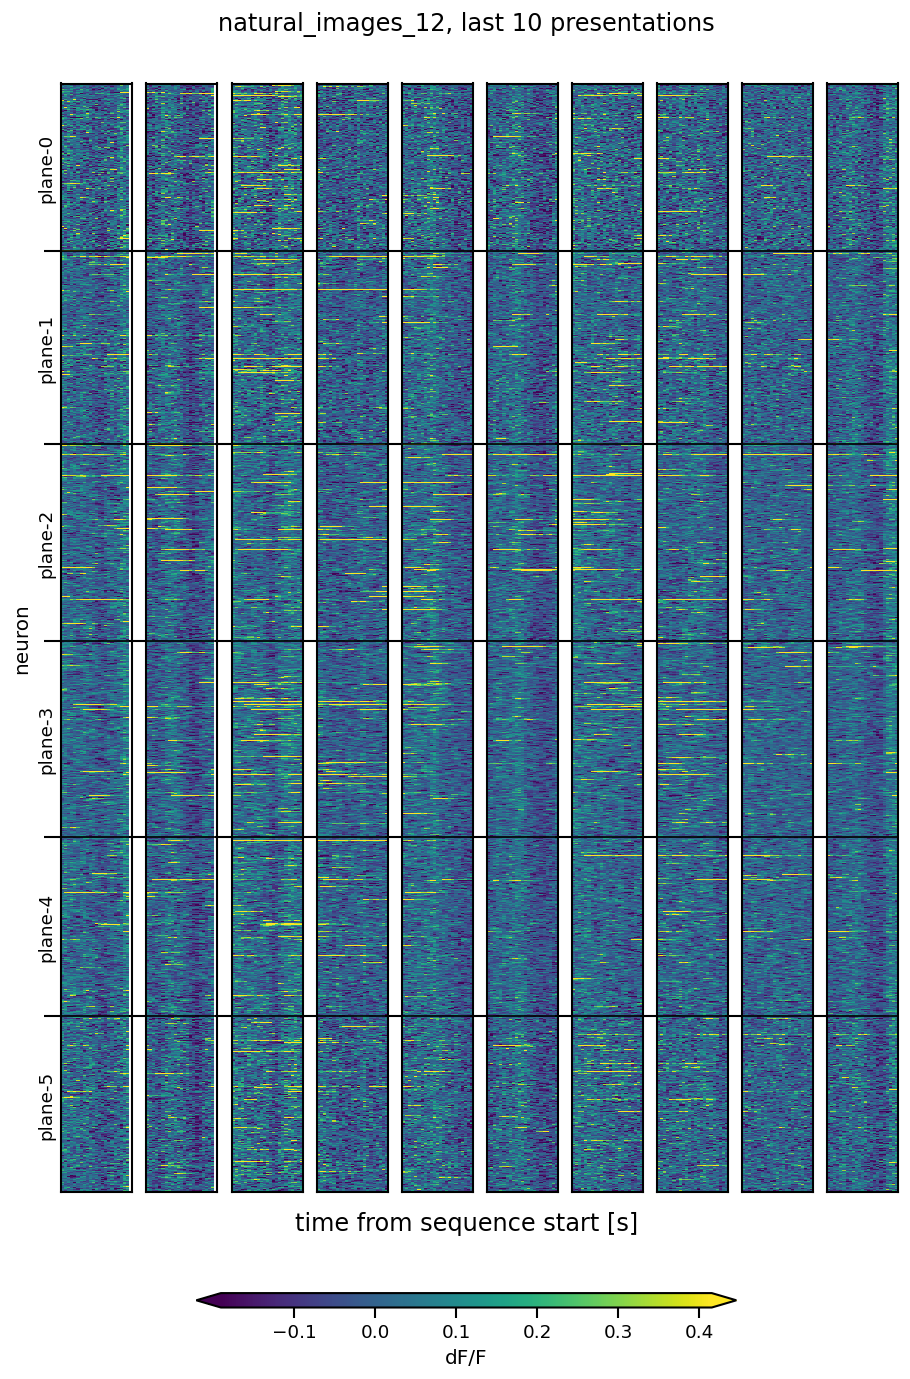

In [11]:
dff = session_data['dff_traces']
plane_ids = session_data['plane_ids']

# Set color norm
norm = mpl.colors.Normalize(
    vmin=np.percentile(dff[:, start_indices[0]:stop_indices[-1]], 1),
    vmax=np.percentile(dff[:, start_indices[0]:stop_indices[-1]], 99),
)

fig, axs = plt.subplots(ncols=10, sharex=True,sharey=True, figsize=(9,12), dpi=120)
for ax, start_index, stop_index in zip(axs, start_indices[-10:], stop_indices[-10:]):
    im = ax.imshow(
        dff[:,start_index:stop_index],
        norm=norm, interpolation='none', aspect='auto'
    )

    for edge in y_cluster_edges:
        ax.axhline(edge, color='k', lw=1)

    # Annotate y-axis with plane
    ax.set_yticks(y_cluster_edges)
    ax.tick_params(axis='y', labelleft=False, length=10)
    
    ax.set_yticks(y_cluster_centers, minor=True)
    ax.set_yticklabels(y_cluster_labels, minor=True, rotation=90, va='center',)
    ax.tick_params(axis='y', which='minor', left=False, length=0)
    
    # Hide x-axis ticks
    ax.tick_params(labelbottom=False, bottom=False)

    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel('neuron')

fig.supxlabel("time from sequence start [s]", y=0.10)

# Add color bar
fig.subplots_adjust(top=0.9, bottom=0.13)
cax = fig.add_axes((0.25,0.05, 0.5, 0.01))   # (l,b,w,h)
fig.colorbar(im, cax=cax, extend='both', label='dF/F', orientation='horizontal')

# Add title
fig.suptitle("natural_images_12, last 10 presentations", y=0.95)

### Regress out behavior

How much of the variability can be explained by differences in behavior?

Let's linearly regress out the activity that is predictive of behavioral variables here and see if that improves the response.

**Load behavior**

In [12]:
def load_aligned_behavior(nwb, refr_timestamps=None):
    # if refr_timestamps is None:

    this_behavior = nwb.processing['behavior'].data_interfaces

    all_names = []
    all_traces = []
    for behavior_name in this_behavior.keys():
        if behavior_name == 'running_speed':
            traces = this_behavior[behavior_name].data[:]
            these_timestamps = this_behavior[behavior_name].timestamps[:]
        else:  # corneal_reflection, pupil
            behavior = this_behavior[behavior_name].to_dataframe()
            traces = behavior['area'].values
            these_timestamps = behavior['timestamps'].values

        # Align timestamps
        if refr_timestamps is None:
            refr_timestamps = these_timestamps
        
        else:
            f_interp = scipy.interpolate.interp1d(
                these_timestamps, traces, 
                kind='linear', bounds_error=False, fill_value="extrapolate",
                axis=-1, # timestamp axis
            )
            traces = f_interp(refr_timestamps)

        all_names.append(behavior_name)
        all_traces.append(traces)

    all_names = np.array(all_names)
    all_traces = np.array(all_traces)
    
    return dict(
        names=all_names,
        traces=all_traces
    )

In [13]:
behavior_data = load_aligned_behavior(nwb, session_data['timestamps'])

In [14]:
behavior_traces =  behavior_data['traces'][:,start_indices[0]:stop_indices[-1]]

# Process the traces a bit
from sklearn.preprocessing import StandardScaler

normd_behavior_traces = []
for i, traces in enumerate(behavior_traces):
    # Standard scale signal
    traces = StandardScaler().fit_transform(traces.reshape(-1,1)).squeeze()

    # Interpolate over any NaNs
    nan_idxs = np.nonzero(np.isnan(traces))[0]
    if len(nan_idxs) > 0:
        print(f"{behavior_data['names'][i]}: {len(nan_idxs)} NaNs detected")
        valid_idxs = np.nonzero(~np.isnan(traces))[0]
        traces[nan_idxs] = np.interp(nan_idxs, valid_idxs, traces[valid_idxs])
    normd_behavior_traces.append(traces)

normd_behavior_traces = np.array(normd_behavior_traces)
normd_behavior_traces.shape


corneal_reflection: 49 NaNs detected
pupil: 53 NaNs detected


(3, 922)

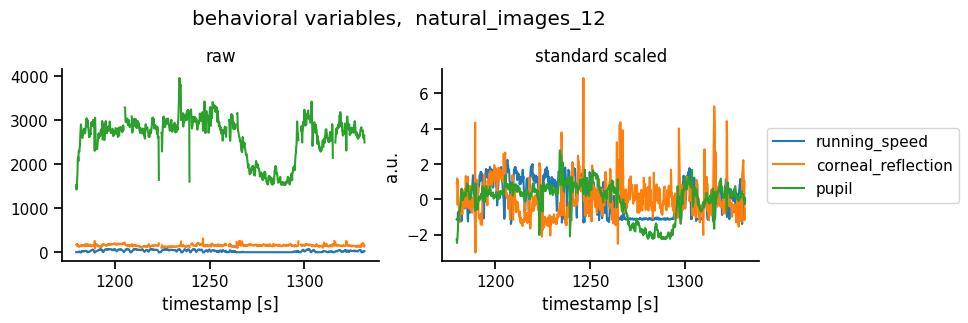

In [15]:
timestamps = session_data['timestamps'][start_indices[0]:stop_indices[-1]]

fig, axs = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(9,3))

ax = axs[0]
for i, name in enumerate(behavior_data['names']):
    ax.plot(timestamps, behavior_traces[i], label=name)
    ax.set_xlabel("timestamp [s]")
ax.set_title('raw')

ax = axs[1]
for i, name in enumerate(behavior_data['names']):
    lc = ax.plot(timestamps, normd_behavior_traces[i], label=name)
    ax.set_ylabel('a.u.')
    ax.set_xlabel("timestamp [s]")
ax.set_title('standard scaled')

# Add legend
ax.legend(loc='center left', bbox_to_anchor=(1,0.5))

fig.subplots_adjust(top=0.75,)
fig.suptitle("behavioral variables,  natural_images_12", y=0.95)
# fig.legend(lc, loc='center left', bbox_to_anchor=(1,0.5))
sns.despine()

**Regress it out**

In [16]:
from sklearn.linear_model import LinearRegression

dff_traces = session_data['dff_traces'][:,start_indices[0]:stop_indices[-1]]
lrm = LinearRegression().fit(normd_behavior_traces.T, dff_traces.T)

print(f"Prediction score: {lrm.score(normd_behavior_traces.T, dff_traces.T):.2f}")

resid_dff_traces = (dff_traces.T - lrm.predict(normd_behavior_traces.T)).T
resid_dff_traces.shape

Prediction score: 0.01


(2708, 922)

Prediction score is quite low, suggesting that behavioral variability is not a significant factor.

Text(0.5, 0.95, 'natural_images_12, first 10 presentations, after regressing out behavior')

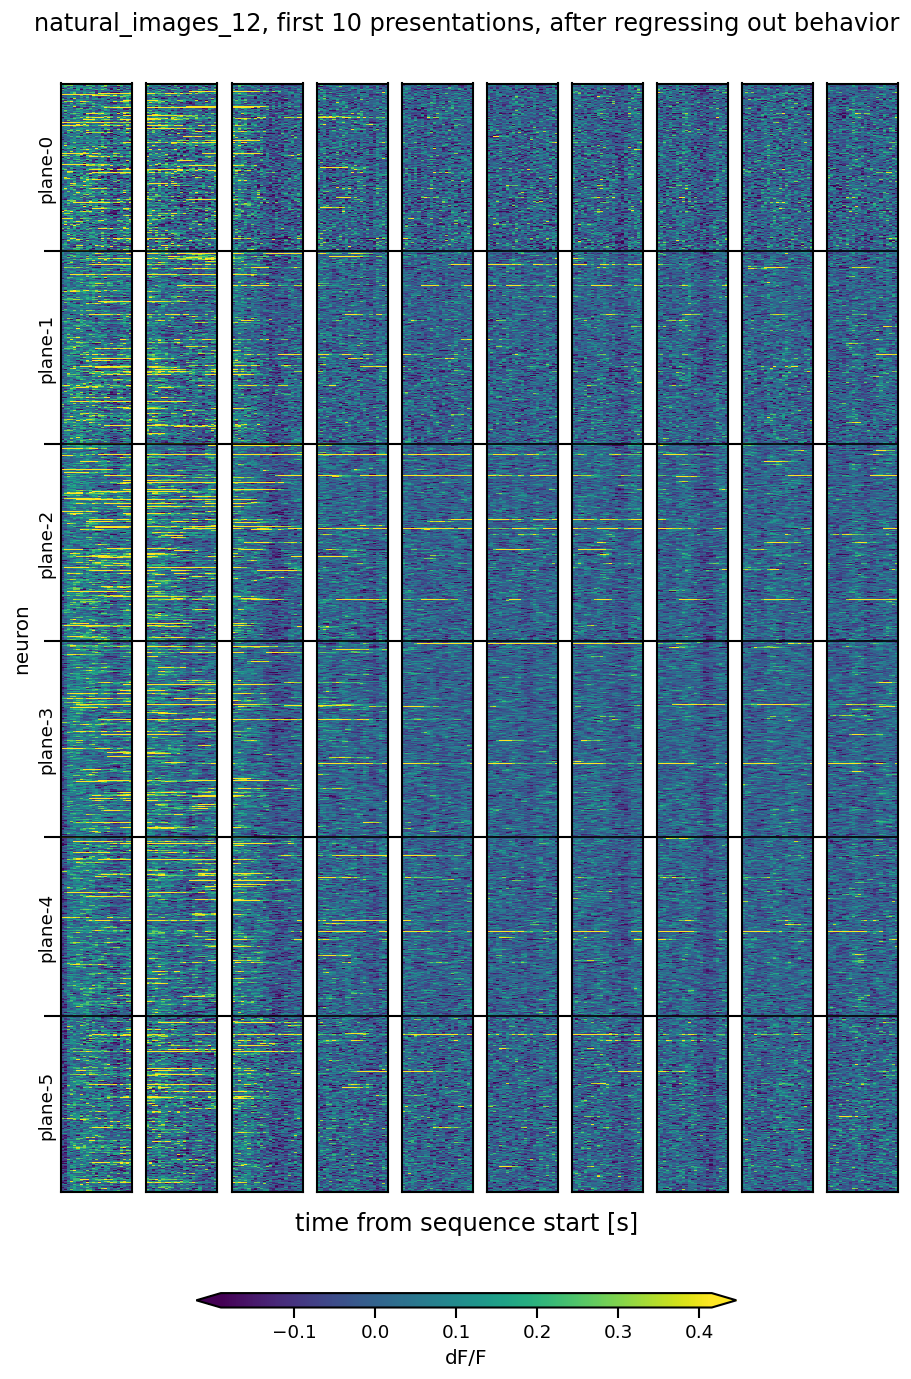

In [17]:
dff = session_data['dff_traces']
plane_ids = session_data['plane_ids']

# Set color norm
norm = mpl.colors.Normalize(
    vmin=np.percentile(dff[:, start_indices[0]:stop_indices[-1]], 1),
    vmax=np.percentile(dff[:, start_indices[0]:stop_indices[-1]], 99),
)

fig, axs = plt.subplots(ncols=10, sharex=True,sharey=True, figsize=(9,12), dpi=120)
for ax, start_index, stop_index in zip(axs, start_indices, stop_indices):
    im = ax.imshow(
        dff[:,start_index:stop_index],
        norm=norm, interpolation='none', aspect='auto'
    )

    for edge in y_cluster_edges:
        ax.axhline(edge, color='k', lw=1)

    # Annotate y-axis with plane
    ax.set_yticks(y_cluster_edges)
    ax.tick_params(axis='y', labelleft=False, length=10)
    
    ax.set_yticks(y_cluster_centers, minor=True)
    ax.set_yticklabels(y_cluster_labels, minor=True, rotation=90, va='center',)
    ax.tick_params(axis='y', which='minor', left=False, length=0)
    
    # Hide x-axis ticks
    ax.tick_params(labelbottom=False, bottom=False)

    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel('neuron')

fig.supxlabel("time from sequence start [s]", y=0.10)

# Add color bar
fig.subplots_adjust(top=0.9, bottom=0.13)
cax = fig.add_axes((0.25,0.05, 0.5, 0.01))   # (l,b,w,h)
fig.colorbar(im, cax=cax, extend='both', label='dF/F', orientation='horizontal')

# Add title
fig.suptitle("natural_images_12, first 10 presentations, after regressing out behavior", y=0.95)

As the linear regresion model score suggestions, behavior is not a significant source of the variability.